# PUC Minas EAD - Trabalho de conclusão de curso

Trabalho de conclusão de curso de Guilherme Fernando Angélico para o título de especialista em Inteligência Artificial e Machine Learning. 28/02/2022

In [1]:
from platform import python_version
print('Versão da linguagem python utilizada para a execução desse notebook:', python_version())

Versão da linguagem python utilizada para a execução desse notebook: 3.9.7


## Detectando transações fraudulentas de cartão de crédito com Inteligência Artificial - Uma abordagem não supervisionada

!['Análise automatica de transações fraldulentas de cartão de crédito'](./images/analise-manual-de-risco.png)

## Definição do problema

Os sistemas comerciais sempre estão em constante evolução, e transacionar uma compra em um e-commerce é uma operação cada vez mais comum; E na mesma velocidade em que as transações ocorrem sempre há uma possibilidade de que essa transação seja fraudulenta, ou seja, não é o dententor do cartão efetuando a compra - uma pessoa maliciosa pode ter capturado esses dados e se passar por essa pessoa.

Nesse projeto, vamos criar um sistema capaz de analisar as transações financeiras e criar um modelo capaz de prever uma classe para cada transação indicando se ela é uma Transação  **Válida** ou um **Fraude**.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from matplotlib import rcParams
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score ,precision_score, recall_score, accuracy_score, precision_recall_curve, classification_report

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [3]:
%reload_ext watermark
%watermark -a "Análise de fraudes em transações com cartões de crédito" --iversions

Author: Análise de fraudes em transações com cartões de crédito

seaborn   : 0.11.2
matplotlib: 3.5.1
tensorflow: 2.8.0
numpy     : 1.22.2
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.4.1



## Dataset

Para modelar nosso sistema de análise de transações fraudulentas vamos utilizar um dataset público disponível no Kaggle:

https://www.kaggle.com/mlg-ulb/creditcardfraud

O dataset possui um total de 31 colunas. Sendo 28 colunas com valores numérico/decimal, obtidos através do processo de PCA - afim de proteger as identidades e recursos confidencias, e outras 3 colunas, sendo: Número de segundos entre a primeira transação do dataset e a atual, O valor da transação e a Classe.

In [4]:
RANDOM_SEED = 42
LABELS = ["Normal", "Fraude"]

In [5]:
df = pd.read_csv('./data/creditcard.zip', sep=',', compression='zip')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Análise do dataset

Vamos analisar o dataset e identicar as caracteristicas das transações desse dataset

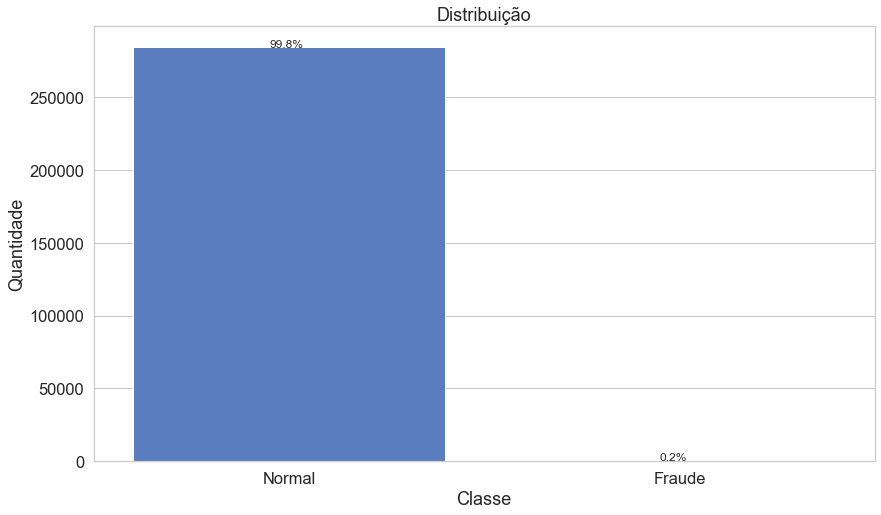

In [6]:
qtd_class = pd.value_counts(df['Class'], sort = True)
plt.title("Distribuição")
ax = sns.barplot(x=qtd_class.keys(), y=qtd_class.values)

for p in ax.patches:
    percent = '{:.1f}%'.format(100 * p.get_height()/len(df))
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percent, (x, y), size=12)

ax.set_xticks(range(len(LABELS)), LABELS)
ax.set_xlabel("Classe")
ax.set_ylabel("Quantidade")
plt.show()

Vamos criar uma coluna de data/tempo para poder colocar nososs registros dentro de uma time series

In [7]:
data_base = dt.datetime(2013, 9, 1, 8, 0, 0)
data_base

datetime.datetime(2013, 9, 1, 8, 0)

In [8]:
df['Data'] = df['Time'].apply(lambda x: data_base + dt.timedelta(seconds=x))

In [9]:
df['Data']

0        2013-09-01 08:00:00
1        2013-09-01 08:00:00
2        2013-09-01 08:00:01
3        2013-09-01 08:00:01
4        2013-09-01 08:00:02
                 ...        
284802   2013-09-03 07:59:46
284803   2013-09-03 07:59:47
284804   2013-09-03 07:59:48
284805   2013-09-03 07:59:48
284806   2013-09-03 07:59:52
Name: Data, Length: 284807, dtype: datetime64[ns]

In [10]:
normal = df[df['Class'] == 0].copy()
fraude = df[df['Class'] == 1].copy()

In [11]:
print('Quantidade de registros normais: ', len(df[df['Class'] == 0]))
print('Quantidade de registros fraldados: ', len(df[df['Class'] == 1]))

Quantidade de registros normais:  284315
Quantidade de registros fraldados:  492


Vamos visualizar a distribuição dos dados

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


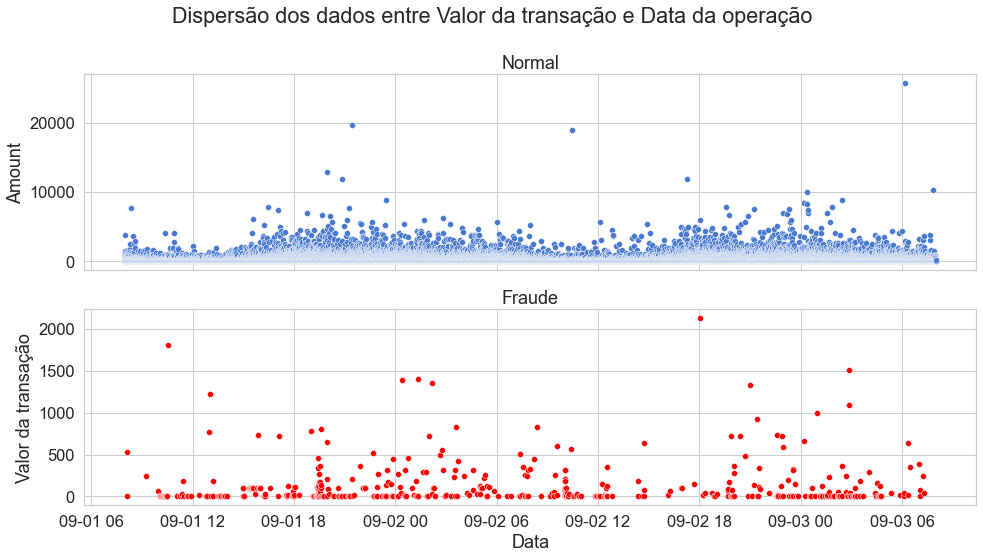

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
plt.suptitle('Dispersão dos dados entre Valor da transação e Data da operação')

ax1.set_title('Normal')
sns.scatterplot(data=normal, x='Data', y='Amount', ax=ax1)

ax2.set_title('Fraude')
sns.scatterplot(data=fraude, x='Data', y='Amount', ax=ax2, color='red')

plt.xlabel('Data')
plt.ylabel('Valor da transação')
plt.tight_layout()
plt.show()

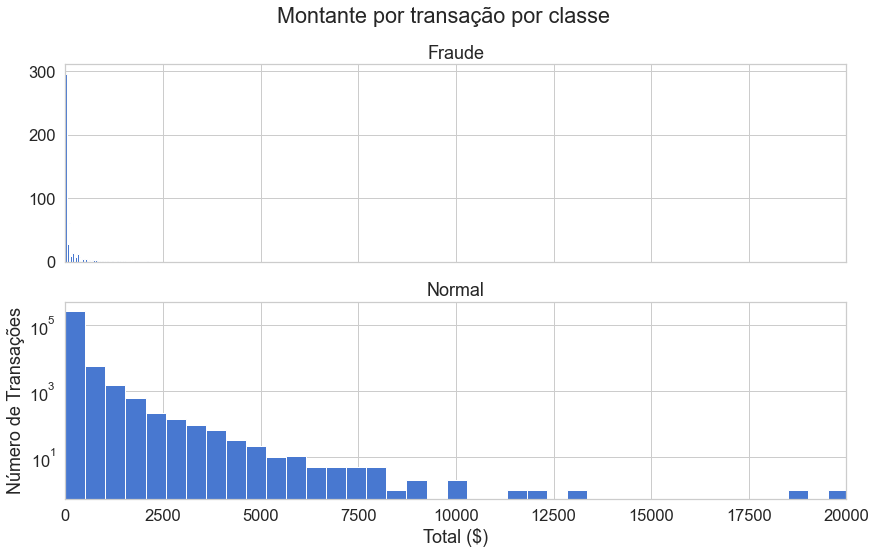

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Montante por transação por classe')

bins = 50

ax1.hist(fraude['Amount'], bins = bins)
ax1.set_title('Fraude')

ax2.hist(normal['Amount'], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Total ($)')
plt.ylabel('Número de Transações')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

<Figure size 1008x576 with 0 Axes>

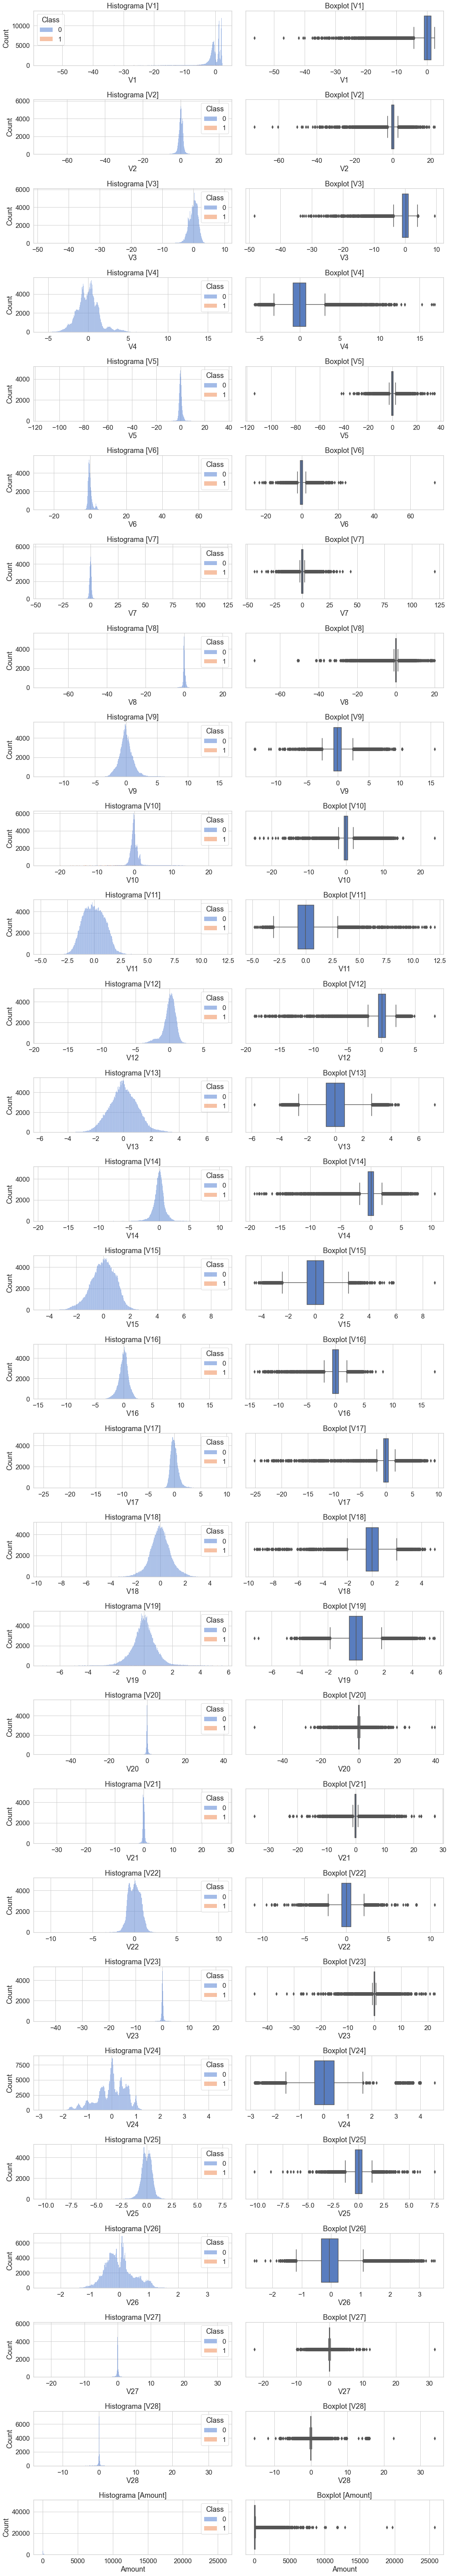

In [15]:
columns = df.columns[1:30]

plt.suptitle('Distribuição e Boxplot dos dados')
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(16,90))

for i, column in enumerate(columns):
    ax0 = axs[i, 0]
    ax0.set_title('Histograma [{}]'.format(column))
    sns.histplot(data=df, x=column, hue='Class', ax=ax0)
    
    ax1 = axs[i, 1]
    ax1.set_title('Boxplot [{}]'.format(column))
    sns.boxplot(data=df, x=column, hue='Class', ax=ax1, orient='h')

plt.tight_layout()
plt.show()

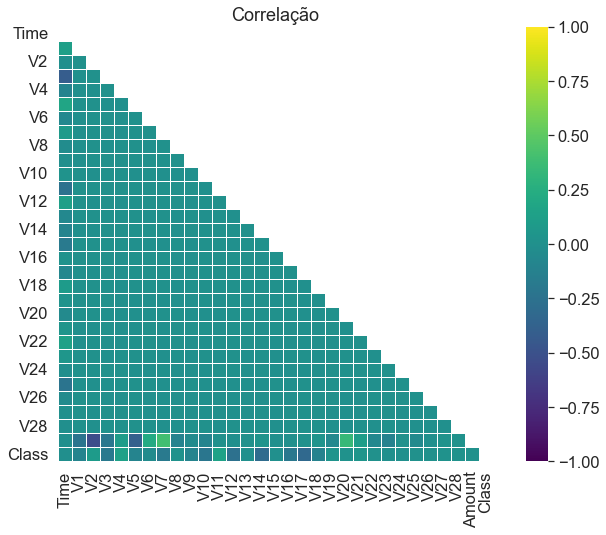

In [16]:
plt.figure(figsize=(12,8))
plt.title('Correlação')

mask = np.zeros_like(df.corr(), dtype=np.bool8)
mask[np.triu_indices_from(mask)]= True


sns.heatmap(df.corr(), mask=mask, square=True, linewidths=0.5, cmap='viridis', vmin=-1, vmax=1, annot_kws={'size': 12})
plt.show()

Podemos notar que não existe uma correlação muito forte entre os dados, apenas uma feature ou outra possui um correlacionamento. Vamos remover os correlacionamentos com valor acima de 50%

In [17]:
CORR = 0.5

In [18]:
corr_matrix = df.drop(columns=['Class', 'Time', 'Data']).corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool8))
                  .unstack()
                  .sort_values(ascending=False))
col_corr = list(map(lambda x: x[1], sol[sol.values > CORR].keys()))
print('Colunas com correlação > {} %'.format(CORR), col_corr)

Colunas com correlação > 0.5 % ['V2']


## Modelagem dos dados


Vamos remover a informação de `Time, Class e Data` e as colunas com correlação do dataset pois esses features não serão utilizadas na previsão e vamos precisar padronizar o valor de `Amount` para que não haja diferença de escala com base nos outros valores das demais features

In [19]:
scaler = StandardScaler()
scaler.fit(df['Amount'].values.reshape(-1, 1))

normal['Amount'] = scaler.transform(normal['Amount'].values.reshape(-1,1))
fraude['Amount'] = scaler.transform(fraude['Amount'].values.reshape(-1,1))

In [20]:
y_normal = normal['Class'].values
y_fraude = fraude['Class'].values

In [21]:
normal = normal.drop(columns=['Class', 'Time', 'Data']).drop(columns=col_corr)
fraude = fraude.drop(columns=['Class', 'Time', 'Data']).drop(columns=col_corr)

## Matriz de custo benefício

Vamos criar uma função para validar aqui o quanto de benefício nosso modelo trará ao identificar as fraudes e o custo que teremos caso essas fraudes passem.

### Definição para a validação do custo/benefício

!['Fraude com cartão'](./images/fraude.png)

https://risk.lexisnexis.com/global/pt/about-us/press-room/press-release/20211020-true-cost-of-fraud-latam

Dado que o valor de uma transação seja 1,00 real e que para uma empresa checar se o consumidor realmenente adquiriu um bem ela gaste 10% desse valor e 386% o valor da transação para solucionar a fraude, qual o impacto operacional se um modelo conseguir impedir uma fraude ?

In [22]:
def calcular_custo_beneficio(tp, fp, tn, fn, valor_transacao = 1.0):
    """Exibe uma matriz de custo/benefício"""
 
    receita_operacional = tp * valor_transacao
    fraude_identificada = fp * valor_transacao * 3.86
    
    receita_validada = tn * valor_transacao * .9
    fraude_validada = tn * valor_transacao * .1
    
    receita_fraudada = fn * valor_transacao * 3.86
    
    print('Total de transações: {}'.format(tp + tn + fp + fn))
    print('-'.center(20, '-'))
    
    print('{} Transações válidas'.format(tp + tn))
    print('= Receita total: {:.2f}'.format(receita_operacional + receita_validada))
    print('+ {} Transações válidas: {:.2f}'.format(tp, receita_operacional))
    print('+ {} Transações checadas: {:.2f}'.format(tn, receita_validada))
    print('- Custom com checagem: {:.2f}'.format(fraude_validada))

    print('-'.center(20, '-'))
    print('{} Fraudes'.format(fp + fn))
    print('- Custo {:.2f}'.format(receita_fraudada))
    print('+ Fraude identificada (save): {:.2f}'.format(fraude_identificada))    

## Base line

Vamos criar um modelo baseline para o nosso modelo principal. O objetivo desse modelo base line e validar como duas estruturas de aprendizados podem chegar a um valor muito próximo um do outro.

Vamos utilizar um classificador do tipo Support Vector Machine para fazer a classificação dos dados. Para isso, vamos obter uma amostra do dataset de registros normais com a mesma quantidade de registros fraudados.

In [23]:
X = normal.sample(len(fraude))
y = y_normal[X.index - 1]

X = pd.concat([X, fraude])
y = np.concatenate((y, y_fraude), axis=None)

Vamos criar as massas de treino e teste e criar o classificador SVM

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [25]:
svc = SVC(kernel='linear', random_state=RANDOM_SEED)
svc.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Vamos verificar como foi o treinamento do modelo

In [26]:
print('Score: {}' .format(svc.score(X_train, y_train)))

Score: 0.9593392630241423


Vamos agora avaliar o teste

In [27]:
y_test_pred = svc.predict(X_test)

In [28]:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[96  3]
 [10 88]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        99
           1       0.97      0.90      0.93        98

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197



Vamos validar se o modelo conseguiria identificar os registros de fraude na base desbalanceada

In [29]:
X = pd.concat([normal, fraude])
y = np.concatenate((y_normal, y_fraude), axis=None)

In [30]:
indexs = np.random.permutation(len(X))

X = X.iloc[indexs]
y = y[indexs]

In [31]:
y_pred = svc.predict(X)

In [32]:
print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

[[272858  11457]
 [    37    455]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.04      0.92      0.07       492

    accuracy                           0.96    284807
   macro avg       0.52      0.94      0.53    284807
weighted avg       1.00      0.96      0.98    284807



Vamos agora validar o quanto o nosso modelo performance em questão de custo/beneficio

In [33]:
cf_svc = pd.DataFrame(confusion_matrix(y, y_pred), columns=LABELS)
cf_svc.index = LABELS
cf_svc

,Normal,Fraude
Normal,272858,11457
Fraude,37,455


In [34]:
calcular_custo_beneficio(cf_svc.loc['Normal']['Normal'], cf_svc.loc['Fraude']['Fraude'],
                           cf_svc.loc['Normal']['Fraude'], cf_svc.loc['Fraude']['Normal'])

Total de transações: 284807
--------------------
284315 Transações válidas
= Receita total: 283169.30
+ 272858 Transações válidas: 272858.00
+ 11457 Transações checadas: 10311.30
- Custom com checagem: 1145.70
--------------------
492 Fraudes
- Custo 142.82
+ Fraude identificada (save): 1756.30


## Arquitetura do modelo

Vamos utilizar um modelo baseado em Autoencoders, com aprendizado não-supervisioinado, para aprender as caracteristicas de transações normais e vamos utilizar do processo de reconstrução para identificar os registros com anomalias, uma vez que os registros com `Fraude` terão um erro de reconstrução maior devido ao modelo não "conhecer" essas caracteristicas que o definem como fraudulento.

!['Autoencoder'](./images/autoencoders.png)

Vamos dividir os dados em treino e teste para criar nosso modelo. Como vamos criar um modelo baseado em `autoencoders` e aprender as caracteristicas das transações válidas, vamos filtrar primeiramente apenas os registros com a classe `Normal` e dividi-los em sub-amostragens para treino e teste. Os registros com classe `Fraude` serão utilizadas apenas no processo de teste.

In [35]:
train, test = train_test_split(normal, test_size=0.2, random_state=RANDOM_SEED)

In [36]:
print('Treino: ', train.shape)
print('Test: ', test.shape)

Treino:  (227452, 28)
Test:  (56863, 28)


In [37]:
features = len(train.columns)
print(features)

28


### Definição do modelo

Vamos definir nosso modelo inicialmente criando a camada de encoder e posterior a camanda de decoder.

In [38]:
tf.keras.backend.clear_session()

In [39]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
input_shape = (features,)
print(input_shape)

(28,)


In [41]:
encoder = Sequential([
    Dense(24, input_shape=input_shape, kernel_initializer='random_normal'),
    BatchNormalization(),
    LeakyReLU(),
    Dense(18, kernel_initializer='random_normal'),
    LeakyReLU(),
    Dense(12, kernel_initializer='random_normal'),
    LeakyReLU(),
    Dense(6, kernel_initializer='random_normal'),
    LeakyReLU(),
], name='encoding')

decoder = Sequential([
    Dense(12, kernel_initializer='random_normal'),
    BatchNormalization(),
    LeakyReLU(),
    Dense(18, kernel_initializer='random_normal'),
    LeakyReLU(),
    Dense(24, kernel_initializer='random_normal'),
    LeakyReLU(),
    Dense(train.shape[1], activation='linear', kernel_initializer='random_normal')
], name='decoding')

In [42]:
model = Sequential([encoder, decoder], name='autoencoder')

In [43]:
model.compile(optimizer = Adam(0.01), loss = 'mse', metrics=['accuracy'])

In [44]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoding (Sequential)       (None, 6)                 1548      
                                                                 
 decoding (Sequential)       (None, 28)                1522      
                                                                 
Total params: 3,070
Trainable params: 2,998
Non-trainable params: 72
_________________________________________________________________


In [45]:
encoder.summary(), decoder.summary()

Model: "encoding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                696       
                                                                 
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 18)                450       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 18)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                228       
                                                          

(None, None)

In [46]:
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, min_lr=0.001, factor=0.01)

In [47]:
cp = ModelCheckpoint('./model/autoencoders.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [48]:
with tf.device('/GPU:0'):
    history = model.fit(train, train, batch_size=256, validation_data=(test, test), epochs=500, callbacks=[cp, rp])

Epoch 1/500
888/889 [============================>.] - ETA: 0s - loss: 0.6662 - accuracy: 0.4250
Epoch 1: val_loss improved from inf to 0.59847, saving model to ./model\autoencoders.h5
889/889 [==============================] - 11s 8ms/step - loss: 0.6661 - accuracy: 0.4251 - val_loss: 0.5985 - val_accuracy: 0.4496 - lr: 0.0100
Epoch 2/500
884/889 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.5446
Epoch 2: val_loss improved from 0.59847 to 0.39607, saving model to ./model\autoencoders.h5
889/889 [==============================] - 7s 8ms/step - loss: 0.4497 - accuracy: 0.5449 - val_loss: 0.3961 - val_accuracy: 0.5788 - lr: 0.0100
Epoch 3/500
889/889 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.6092
Epoch 3: val_loss improved from 0.39607 to 0.36409, saving model to ./model\autoencoders.h5
889/889 [==============================] - 7s 8ms/step - loss: 0.3380 - accuracy: 0.6092 - val_loss: 0.3641 - val_accuracy: 0.5708 - lr: 0.0100
Epoc

### Avaliando o treinamento do modelo

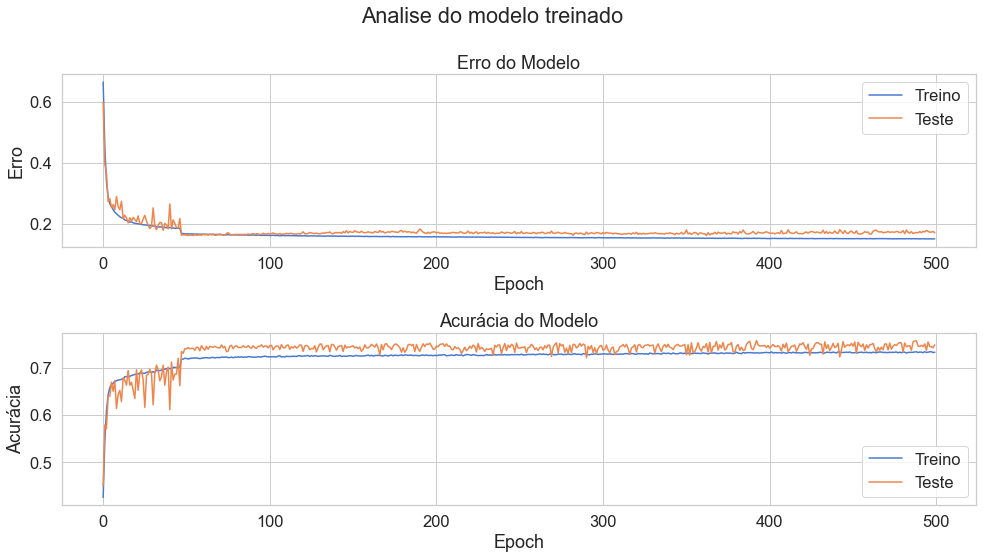

In [49]:
plt.suptitle('Analise do modelo treinado')

plt.subplot(211)
plt.title('Erro do Modelo')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Erro')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'best')

plt.subplot(212)
plt.title('Acurácia do Modelo')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Teste'], loc = 'best')

plt.tight_layout()
plt.show()

### Carregando o modelo treinado

In [50]:
model = tf.keras.models.load_model('./model/autoencoders.h5') 

### Executando o modelo para prever as classes de testes

Vamos inserir agora nos dados de testes os registros de fraude e validar como o modelo conseguirá classificar os registros de fraude

In [51]:
test = pd.concat([test, fraude])
test = test.iloc[np.random.permutation(len(test))]

In [52]:
test_pred = model.predict(test)

Vamos identificar agora o erro da reconstrução gerada pelo modelo. O erro de reconstrução vai ser utilizado para prever a probabilidade de uma amostra ser uma instância fraudada. 

O fato de termos utilizado apenas registros `normais` para o treinamento do modelo do autoencoder é que durante o processo de inferência os registros com fraude perde as caracteristicas da fraude e o decodificador as reconstroi como sendo um registro normal, resultando em um grande erro de reconstrução.

Depois de calcular todos os erros no dataset de teste podemos gerar uma probabilidade, entre 0 e 1, indicando o percentual de anômalia que essa instancia possui. Com base nisso, podemos definir um threshold para limitar quais registros são anômalos.

### Função de calculo de erro para reconstrução

Vamos buscar as labels para os registros de teste

In [53]:
labels = df.iloc[test.index]['Class'].values

Vamos utilizar o erro quadrático médio para achar o erro de reconstrução do modelo.

$$\textstyle L(x,x') = ||\, x - x'||^2$$

In [54]:
labels_pred = np.mean(np.power(test-test_pred, 2), axis=1)

In [55]:
labels_pred = np.array(labels_pred).reshape(-1,1)

In [56]:
labels_pred[0:5]

array([[0.04773151],
       [0.10050023],
       [0.02836452],
       [0.07898993],
       [0.03723999]])

Vamos normalizar os erros para eles ficarem em uma mesma escala

In [57]:
erro_scaler = MinMaxScaler()
previsao_fraude = erro_scaler.fit_transform(labels_pred).flatten()

In [58]:
previsao_fraude[0:5]

array([1.22223706e-04, 2.72522855e-04, 6.70614480e-05, 2.11255881e-04,
       9.23411345e-05])

In [59]:
true_labels = [i for i, label in enumerate(labels) if label == 1]

print(labels[true_labels[0:5]])
print(previsao_fraude[true_labels[0:5]])

[1 1 1 1 1]
[0.02331378 0.01035932 0.00243264 0.00073656 0.0216671 ]


Vamos verificar agora se o modelo foi capaz de identificar as anomalias nas transações.

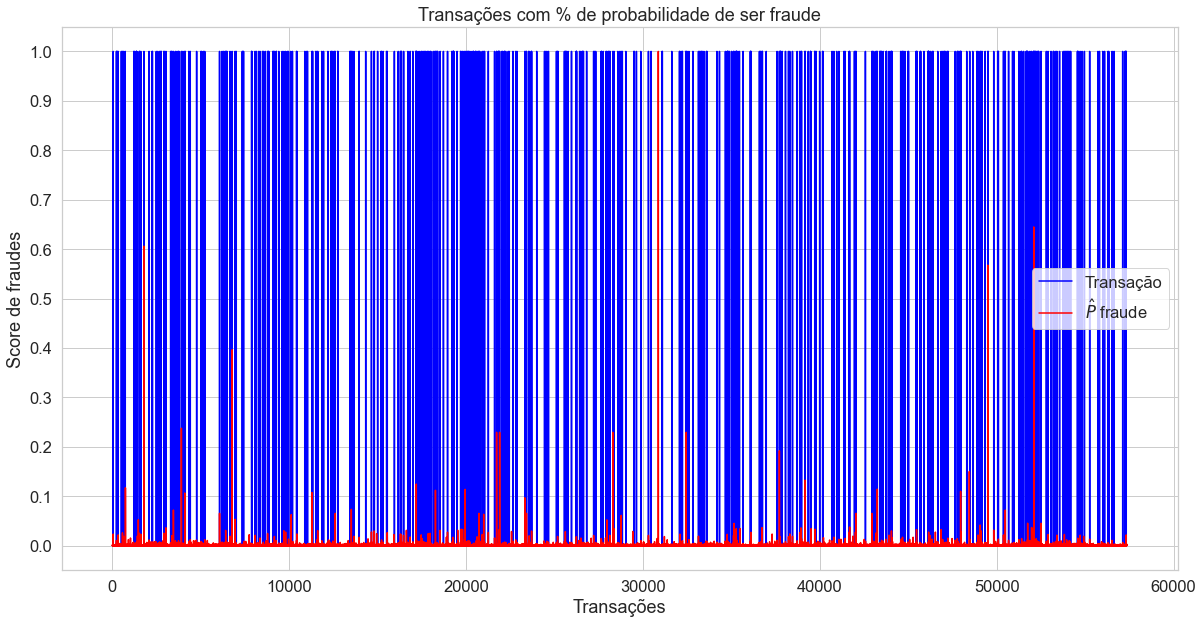

In [60]:
plt.figure(figsize=(20,10))
plt.title('Transações com % de probabilidade de ser fraude')
plt.plot(labels, c='blue', label='Transação')
plt.plot(previsao_fraude, c='red', label='$\hat{P}$ fraude')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Transações')
plt.ylabel('Score de fraudes')
plt.legend()
plt.show()

## Avaliação do modelo

Vamos avaliar agora se o nosso modelo teve uma boa taxa de acerto nos dados de testes. Vamos utilizar a curva ROC-AUC para medir a eficácia de nosso modelo em distingir as duas classes. 

Valores perto do canto superior esquerdo, perto de 1, indicam que o classificar é bom em distinguir as classes e valores abaixo da área média, perto de 0.5, indicam que o modelo não conseguiu distinguir entre as classes.

In [61]:
fpr, tpr, threshold = roc_curve(labels, previsao_fraude)

In [62]:
score_auc = roc_auc_score(labels, previsao_fraude)
print('Score AUC: ', score_auc)

Score AUC:  0.9411255036173807


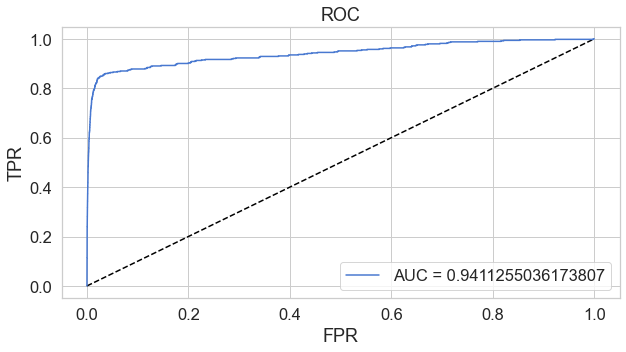

In [63]:
plt.figure(figsize = (10,5))
plt.title('ROC')
plt.plot([0, 1], [0, 1], color = 'black', linestyle = '--')
plt.plot(fpr, tpr, label = 'AUC = {}'.format(score_auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Nosso modelo conseguiu classificar bem os eventos com transações com as duas labels. Porém como temos dados desbalanceados o ROC pode não expressar corretamente o quao bom ou ruim esta nosso modelo. Vamos utilizar para isso outras métricas de avaliação.

## Precisão vs Recal

!['Precisao vs Recall'](./images/precision_recall.png)

Precisão e Recall são métricas para avaliar o quanto um modelo esta conseguindo identificar as classes corretas durante um processo de classificação. Porém a precisão e o recall tem objetivos distintos na identificação do quão bem o modelo esta classificando.

Precisão e recall são definidos da seguinte forma:

$$\text{Precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

$$\text{Recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

* A precisão mede a relevância dos resultados obtidos. 

* Recall, por outro lado, mede quantos resultados relevantes são retornados.

Ambos os valores podem ter valores entre 0 e 1.

Vamos calcular agora os valores e plotar em um gráfico

In [64]:
precision, recall, th = precision_recall_curve(labels, previsao_fraude)

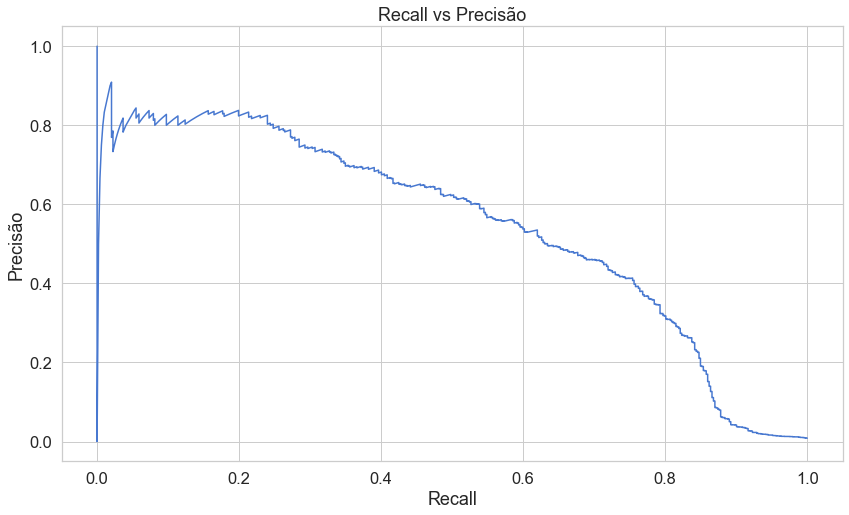

In [65]:
plt.title('Recall vs Precisão')
plt.plot(recall, precision, 'b', label = 'Curva Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

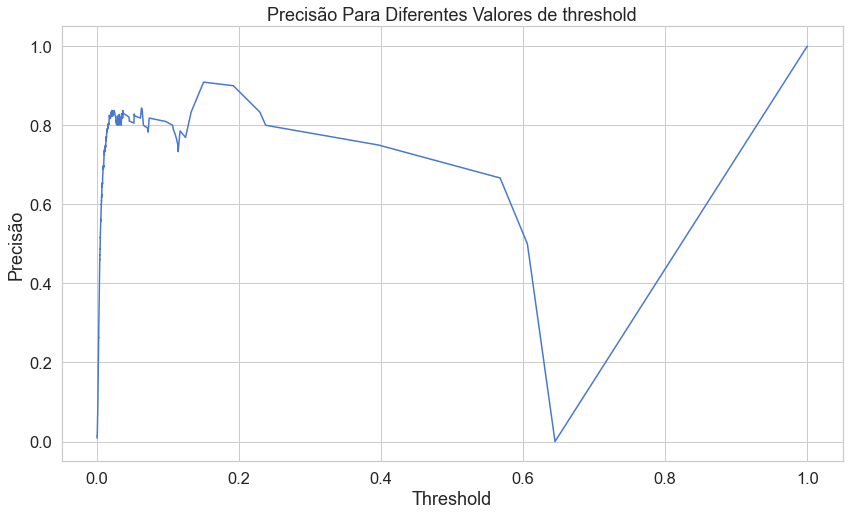

In [66]:
plt.plot(th, precision[1:], 'b', label = 'Curva Threshold-Precisão')
plt.title('Precisão Para Diferentes Valores de threshold')
plt.xlabel('Threshold')
plt.ylabel('Precisão')
plt.show()

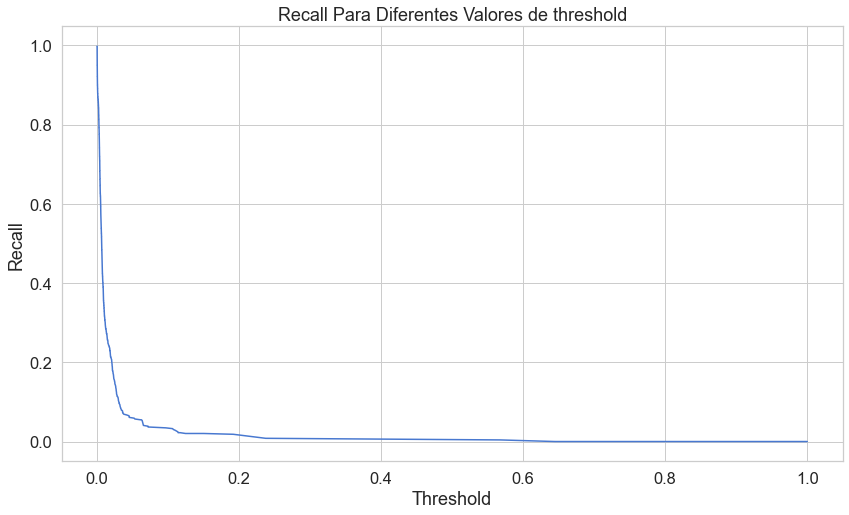

In [67]:
plt.plot(th, recall[1:], 'b', label = 'Curva Threshold-Recall')
plt.title('Recall Para Diferentes Valores de threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

## Identificando fraudes

Precisamos agora definir um limite de threshold para o nosso modelo. Valores acima desse limite indicaram que os registros possuem fraude na transação, então precisamos achar um valor que consiga identificar o maior número possível de fraudes.

Vamos utilizar como base a métrica de F1-Score, que é uma média harmônica de precisão e recall.

In [68]:
limites_fraude = [(previsao_fraude > i).astype(np.int32) for i in threshold]
f1_scores = [f1_score(labels, i) for i in limites_fraude]

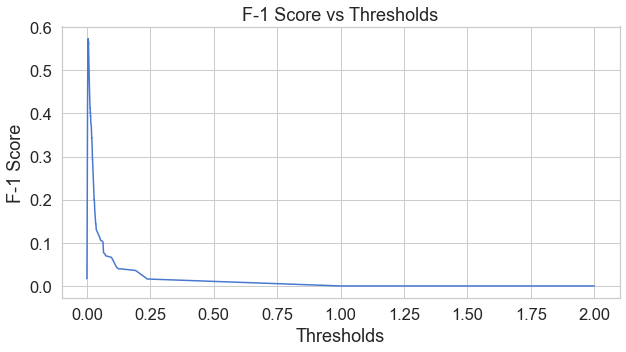

In [69]:
plt.figure(figsize = (10, 5))
plt.title('F-1 Score vs Thresholds')
plt.plot(threshold, f1_scores)
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.show()

Vamos obter o melhor threshold

In [70]:
print(np.min(f1_scores))
print(np.max(f1_scores))

0.0
0.5730442978322338


In [71]:
threshold

array([2.00000000e+00, 1.00000000e+00, 2.37430743e-01, ...,
       8.34517287e-06, 8.33922736e-06, 0.00000000e+00])

In [72]:
melhor_threshold = threshold[f1_scores.index(np.max(f1_scores))]
print('Melhor Threshold = {}'.format(melhor_threshold))

Melhor Threshold = 0.004779730771030043


Vamos agora classificar nossos registros com base nesse threshold

In [138]:
ajuste =  0.00363

In [139]:
indicador_fraude = (previsao_fraude > (melhor_threshold - ajuste)).astype(np.int32)

In [140]:
indicador_fraude

array([0, 0, 0, ..., 1, 0, 0])

Vamos analisar agora como ficou as classificações dos registros com base no threshold selecionado

In [141]:
cf_model = pd.DataFrame(confusion_matrix(labels, indicador_fraude), columns=LABELS)
cf_model.index = LABELS
print(cf_model)

        Normal  Fraude
Normal   53075    3788
Fraude      64     428


In [142]:
indicador_fraude_final = ['normal' if i == 0 else 'fraude' for i in indicador_fraude]

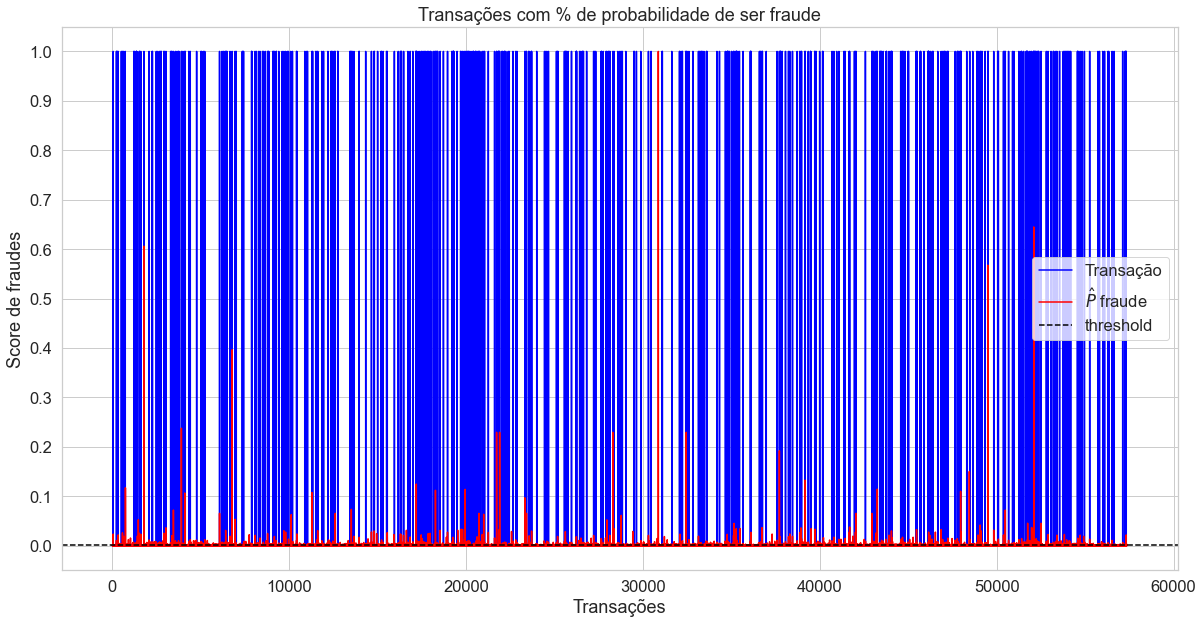

In [143]:
plt.figure(figsize=(20,10))
plt.title('Transações com % de probabilidade de ser fraude')
plt.plot(labels, c='blue', label='Transação')
plt.plot(previsao_fraude, c='red', label='$\hat{P}$ fraude')

plt.axhline(y = (melhor_threshold - ajuste), linestyle = '--', label = 'threshold', color='black')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Transações')
plt.ylabel('Score de fraudes')
plt.legend()
plt.show()

## Metricas de performance

In [144]:
precision = precision_score(labels, indicador_fraude)
recall = recall_score(labels, indicador_fraude)
f1_sc = f1_score(labels, indicador_fraude)
accuracy_sc = accuracy_score(labels, indicador_fraude)

In [145]:
print("""Métricas de Avaliação do Modelo:
         Precision = {}
         Recall = {}
         Score F1 = {}
         Acurácia = {}"""
      .format(precision, recall, f1_sc, accuracy_sc))

Métricas de Avaliação do Modelo:
         Precision = 0.1015180265654649
         Recall = 0.8699186991869918
         Score F1 = 0.1818181818181818
         Acurácia = 0.9328393339726266


In [146]:
print(classification_report(labels, indicador_fraude))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56863
           1       0.10      0.87      0.18       492

    accuracy                           0.93     57355
   macro avg       0.55      0.90      0.57     57355
weighted avg       0.99      0.93      0.96     57355



In [147]:
calcular_custo_beneficio(cf_model.loc['Normal']['Normal'], cf_model.loc['Fraude']['Fraude'],
                           cf_model.loc['Normal']['Fraude'], cf_model.loc['Fraude']['Normal'])

Total de transações: 57355
--------------------
56863 Transações válidas
= Receita total: 56484.20
+ 53075 Transações válidas: 53075.00
+ 3788 Transações checadas: 3409.20
- Custom com checagem: 378.80
--------------------
492 Fraudes
- Custo 247.04
+ Fraude identificada (save): 1652.08


## Conclusão

Conseguimos chegar a um resultado muito próximo do modelo de classificação feito pelo SVM utilizando Autoencoders. A diferença entre o modelo de aprendizados de ambas abordagem são bem diferentes mas chegaram a resultados muito próximos. É claro que não conseguimos igualar ou ultrapassar o modelo de aprendizado supervisionado utilizando o aprendizado não supervisionado, mas podemos melhorar ainda mais o modelo e assim conseguir chegar em um resultado mais satisfatório.